In [1]:
from autoencoder import Autoencoder
from compute_results import plot_roc_curve, get_overall_metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import torch
import os

In [2]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Importing preprocessed data

In [3]:
PATH_TRAIN_MAJBA_CSV = '../data/train_MajBa_preprocessed.csv'
PATH_VAL_MAJBA_CSV = '../data/val_MajBa_preprocessed.csv'
PATH_TEST_MAJBA_CSV = '../data/test_MajBa_preprocessed.csv'

df_train = pd.read_csv(PATH_TRAIN_MAJBA_CSV)
df_val = pd.read_csv(PATH_VAL_MAJBA_CSV)
df_test = pd.read_csv(PATH_TEST_MAJBA_CSV)

In [4]:
def split_features_labels_and_domains_columns(df):
    X = df.drop(['domain', 'label', 'malware'], axis='columns')
    y = df['label']
    domains = df['domain']
    malwares = df['malware']
    return X,y,domains,malwares

X_train, y_train, domains_train, malwares_train = split_features_labels_and_domains_columns(df_train)
X_val, y_val, domains_val, malwares_val = split_features_labels_and_domains_columns(df_val)
X_test, y_test, domains_test, malwares_test = split_features_labels_and_domains_columns(df_test)

## Preparing autoencoder training data

We must remove malicious instances for autoencoder training

In [5]:
X_train_benign = X_train[y_train == 0].reset_index(drop=True)

In [6]:
X_train_benign.shape

(281248, 47)

Normalizing

In [7]:
from sklearn.preprocessing import StandardScaler

# For AxAm training set
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train_benign)

X_train_benign_norm = std_scaler.transform(X_train_benign)
X_val_norm = std_scaler.transform(X_val)
X_test_norm = std_scaler.transform(X_test)

X_train_benign_norm = torch.tensor(X_train_benign_norm, dtype=torch.float32)
X_val_norm = torch.tensor(X_val_norm, dtype=torch.float32)
X_test_norm = torch.tensor(X_test_norm, dtype=torch.float32)

# Modelling with Autoencoder

In [8]:
HIDDEN_LAYERS_DIM = (40, 35, 25, 15, 10, 15, 25, 35, 40)
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 45
BATCH_SIZE = 128
PATIENCE = 6
DELTA = 0.002

In [10]:
# # HIDDEN_LAYERS_DIM2 = (45, 40, 35, 25, 15, 10, 15, 25, 35, 40, 45)   # AUC=0.85780
# # HIDDEN_LAYERS_DIM3 = (35, 20, 10, 20, 30)                           # AUC=0.85265
# # HIDDEN_LAYERS_DIM4 = (32, 16, 8, 16, 32)                            # AUC=0.86286
# # HIDDEN_LAYERS_DIM5 = (32, 16, 5, 16, 32)                            # AUC=0.87752

# model_ae_MajBa = Autoencoder(in_features=X_train_benign_norm.shape[1], 
#                        hidden_layers_dims=HIDDEN_LAYERS_DIM,
#                        dropout_rate=0.0)
# model_ae_MajBa.compile(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# model_ae_MajBa, train_avg_losses_MajBa, val_avg_losses_MajBa = model_ae_MajBa.fit(
#                                                 X_train=X_train_benign_norm,
#                                                 num_epochs= NUM_EPOCHS,
#                                                 batch_size=BATCH_SIZE,
#                                                 X_val=X_val_norm,
#                                                 y_val=y_val,
#                                                 patience=PATIENCE,
#                                                 delta=DELTA,
#                                                 es_criterion='aucroc'
#                                             )

Using early stopping with patience=6, delta=0.002 and es_criterion=aucroc


100%|██████████| 2198/2198 [00:06<00:00, 318.11it/s]


Epoch#1: Train Average Loss = 0.76076
Validation score improved (-inf --> 0.90461).  Saving model ...


100%|██████████| 2198/2198 [00:08<00:00, 270.70it/s]


Epoch#2: Train Average Loss = 0.67506
Validation score improved (0.90461 --> 0.91148).  Saving model ...


100%|██████████| 2198/2198 [00:07<00:00, 288.30it/s]


Epoch#3: Train Average Loss = 0.63983
EarlyStopping counter: 1 out of 6. Current validation score: 0.90786


100%|██████████| 2198/2198 [00:07<00:00, 291.31it/s]


Epoch#4: Train Average Loss = 0.62683
EarlyStopping counter: 2 out of 6. Current validation score: 0.90680


100%|██████████| 2198/2198 [00:07<00:00, 283.50it/s]


Epoch#5: Train Average Loss = 0.61967
EarlyStopping counter: 3 out of 6. Current validation score: 0.90624


100%|██████████| 2198/2198 [00:07<00:00, 278.22it/s]


Epoch#6: Train Average Loss = 0.61154
EarlyStopping counter: 4 out of 6. Current validation score: 0.90648


100%|██████████| 2198/2198 [00:08<00:00, 274.28it/s]


Epoch#7: Train Average Loss = 0.60385
EarlyStopping counter: 5 out of 6. Current validation score: 0.90816


100%|██████████| 2198/2198 [00:07<00:00, 278.28it/s]


Epoch#8: Train Average Loss = 0.59776
EarlyStopping counter: 6 out of 6. Current validation score: 0.90880


100%|██████████| 2198/2198 [00:08<00:00, 259.75it/s]


Epoch#9: Train Average Loss = 0.59318
EarlyStopping counter: 7 out of 6. Current validation score: 0.90852
Stopped by early stopping at epoch 9


In [10]:
model_ae_MajBa = torch.load('../experiments/model_ae_MajBa.pt')

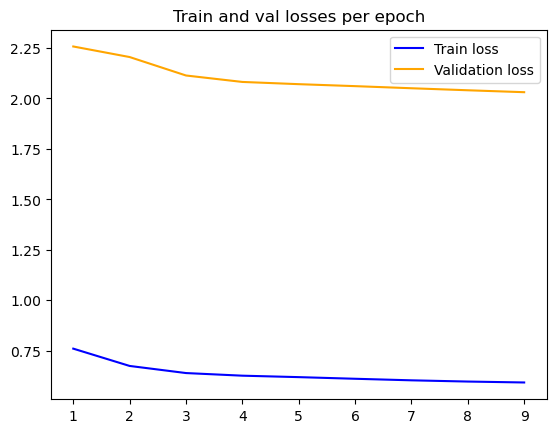

In [12]:
# def plot_train_val_losses(train_avg_losses, val_avg_losses):
#   epochs = list(range(1, len(train_avg_losses)+1))
#   plt.plot(epochs, train_avg_losses, color='blue', label='Train loss')
#   plt.plot(epochs, val_avg_losses, color='orange', label='Validation loss')
#   plt.title('Train and val losses per epoch')
#   plt.legend()

# plot_train_val_losses(train_avg_losses_MajBa, val_avg_losses_MajBa)

# Defining a threshold and computing results

In [11]:
def get_autoencoder_anomaly_scores(model_ae, X):
  X = torch.FloatTensor(X)
  reconstructed_X = model_ae(X)
  anomaly_scores = torch.mean(torch.pow(X - reconstructed_X, 2), axis=1).detach().numpy() # MSELoss
  return anomaly_scores

### Validation Set

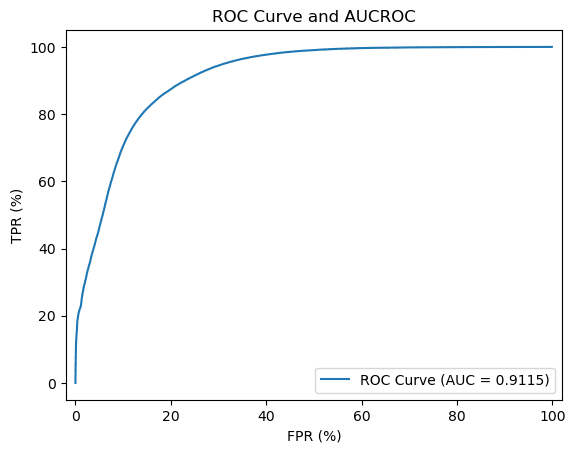

In [15]:
val_anomaly_scores_MajBa = get_autoencoder_anomaly_scores(model_ae_MajBa, X_val_norm)
plot_roc_curve(y_val, val_anomaly_scores_MajBa)

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores_MajBa)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
BEST_VALIDATION_THRESHOLD_AXAM = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [17]:
get_overall_metrics(y_val, val_anomaly_scores_MajBa > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.8362983255845676,
 'tpr': 0.856995121239035,
 'fpr': 0.18184727303757905,
 'precision': 0.8051367631762433,
 'f1-score': 0.8302569542668552}

### Test set

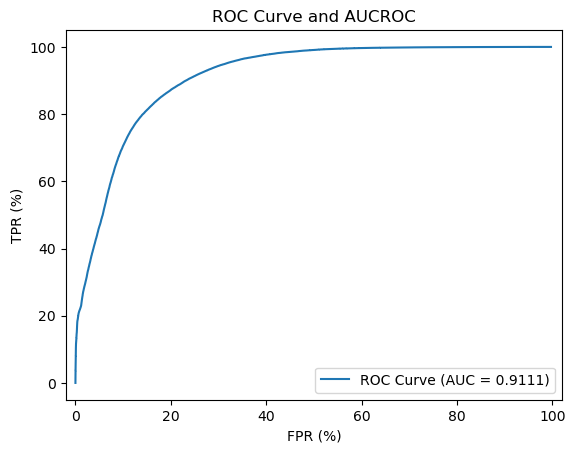

In [12]:
test_anomaly_scores_MajBa = get_autoencoder_anomaly_scores(model_ae_MajBa, X_test_norm)
plot_roc_curve(y_test, test_anomaly_scores_MajBa)

In [21]:
get_overall_metrics(y_test, test_anomaly_scores_MajBa > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.8345368515281981,
 'tpr': 0.8560543845241354,
 'fpr': 0.184328,
 'precision': 0.802825700006846,
 'f1-score': 0.8285860646688394}

In [13]:
# best_possible_test_threshold

fpr, tpr, thresholds = roc_curve(y_test, test_anomaly_scores_MajBa)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_possible_test_threshold_AxAm = df_val_roc.sort_values('youden-index', ascending=False).query('fpr < 0.01').iloc[0]['thresholds']

In [14]:
get_overall_metrics(y_test, test_anomaly_scores_MajBa > best_possible_test_threshold_AxAm)

{'acc': 0.6309390852124984,
 'tpr': 0.22137968792773063,
 'fpr': 0.009992,
 'precision': 0.9510388083104665,
 'f1-score': 0.3591561806069578}